In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns 
import pickle
import os
import numpy as np

from collections import defaultdict
from collections import Counter
import itertools

from scipy.signal import find_peaks
from scipy import stats
from diptest import diptest

In [ ]:
os.chdir("./gabi_rotation")

# Investigate the run time characteristics of different SPECTRA jobs

In [3]:
job_stats = pd.read_csv('spectra_job_stats.csv')
job_stats['n_samples'] = job_stats['n_samples'].replace(-1, 261290)
job_stats

,jobid,n_samples,highly_variable,n_epochs,eigen_factor_used,wall_clock_time,memory_used,node,cpu_efficiency
0,325979,10000,3000,5,False,00:15:41,20.70,c4-n29,95.86%
1,325982,50000,3000,5,False,00:35:16,24.79,c4-n29,98.35%
2,325985,100000,3000,5,False,01:36:35,32.60,c4-n29,98.71%
3,325988,261290,3000,5,False,03:02:08,48.52,c4-n26,98.98%
4,326190,10000,3000,100,False,01:32:33,20.74,c4-n26,98.60%
5,326203,50000,3000,100,False,02:23:21,26.64,c4-n26,98.44%
6,326209,261290,3000,100,False,03:03:00,50.52,c4-n26,98.30%
7,326206,100000,3000,100,False,03:08:25,33.48,c4-n26,99.04%
8,328921,100000,3000,1000,False,09:15:09,34.50,c4-n29,99.17%
9,328924,100000,3000,2000,False,17:47:30,34.56,c4-n31,99.32%


# See how n_sample scales at different epochs

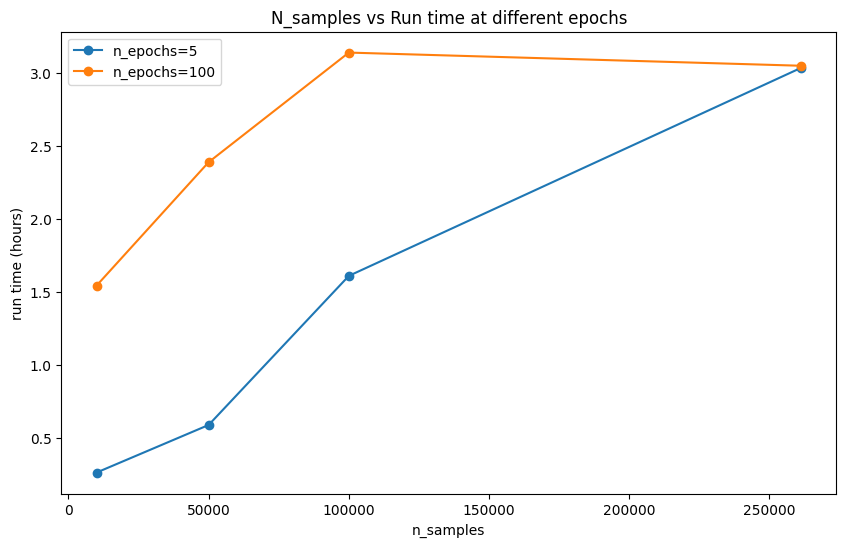

In [4]:
# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot lines for each n_epochs value
for epoch in [5, 100]:
   data = job_stats[job_stats['n_epochs'] == epoch].sort_values('n_samples')
   times = pd.to_timedelta(data['wall_clock_time']).dt.total_seconds() / 3600
   plt.plot(data['n_samples'], times, 'o-', label=f'n_epochs={epoch}')

plt.xlabel('n_samples')
plt.ylabel('run time (hours)') 
plt.title('N_samples vs Run time at different epochs')
plt.legend()
plt.show()

# Look at how SPECTRA scales at different epochs

In [5]:
# Function to convert 'D-HH:MM:SS' or 'HH:MM:SS' to timedelta
def parse_time_format(time_str):
    if '-' in time_str:
        days, time_part = time_str.split('-')
        time_str = f"{days} days {time_part}"
    return pd.to_timedelta(time_str)

In [6]:
job_stats

,jobid,n_samples,highly_variable,n_epochs,eigen_factor_used,wall_clock_time,memory_used,node,cpu_efficiency
0,325979,10000,3000,5,False,00:15:41,20.70,c4-n29,95.86%
1,325982,50000,3000,5,False,00:35:16,24.79,c4-n29,98.35%
2,325985,100000,3000,5,False,01:36:35,32.60,c4-n29,98.71%
3,325988,261290,3000,5,False,03:02:08,48.52,c4-n26,98.98%
4,326190,10000,3000,100,False,01:32:33,20.74,c4-n26,98.60%
5,326203,50000,3000,100,False,02:23:21,26.64,c4-n26,98.44%
6,326209,261290,3000,100,False,03:03:00,50.52,c4-n26,98.30%
7,326206,100000,3000,100,False,03:08:25,33.48,c4-n26,99.04%
8,328921,100000,3000,1000,False,09:15:09,34.50,c4-n29,99.17%
9,328924,100000,3000,2000,False,17:47:30,34.56,c4-n31,99.32%


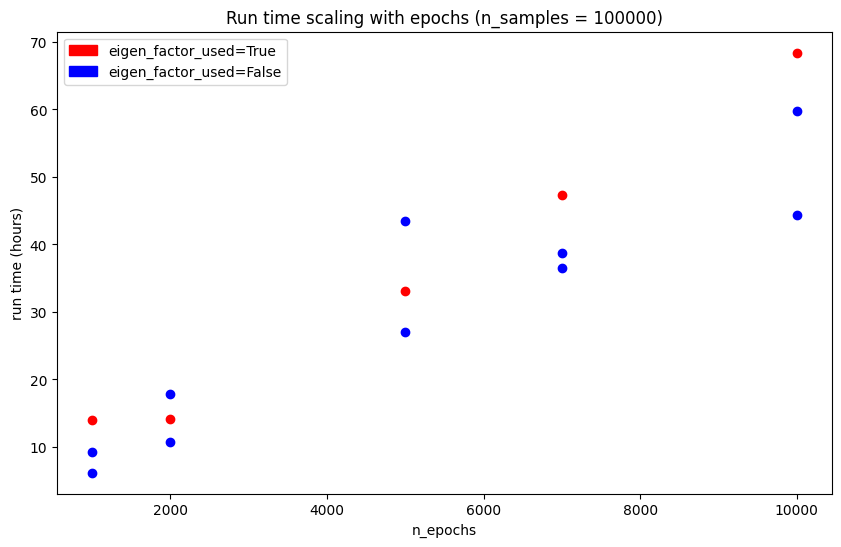

In [7]:
# Filter and sort data
data = job_stats[job_stats['n_epochs'] > 100].sort_values('n_epochs')
times = data['wall_clock_time'].apply(parse_time_format).dt.total_seconds() / 3600

# Define colors based on 'eigen_factor_used'
colors = data['eigen_factor_used'].map({True: 'red', False: 'blue'})

# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot each point with color
for epoch, time, color in zip(data['n_epochs'], times, colors):
    plt.plot(epoch, time, 'o-', color=color)

# Add labels and title
plt.xlabel('n_epochs')
plt.ylabel('run time (hours)')
plt.title('Run time scaling with epochs (n_samples = 100000)')

# Create custom legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='eigen_factor_used=True')
blue_patch = mpatches.Patch(color='blue', label='eigen_factor_used=False')
plt.legend(handles=[red_patch, blue_patch])

# Show plot
plt.show()

# Load and analyze models

In [3]:
adatas = {}
for epoch in [10000]:
    for bulk_status in [True,False]:
        with open(f'adatas/skin_data_100000cells_{epoch}epochs_bulk{bulk_status}.pickle', 'rb') as f:
            adata = pickle.load(f)
            adatas[(epoch,bulk_status)] = adata

In [9]:
models = {}
for epoch in [7000,10000]:
    #and load it like this:
    for bulk_status in [True,False]:
        with open(f'models/skin_model_100000cells_{epoch}epochs_bulk{bulk_status}.pickle', 'rb') as f:
            model = pickle.load(f)
            models[(epoch,bulk_status)] = model

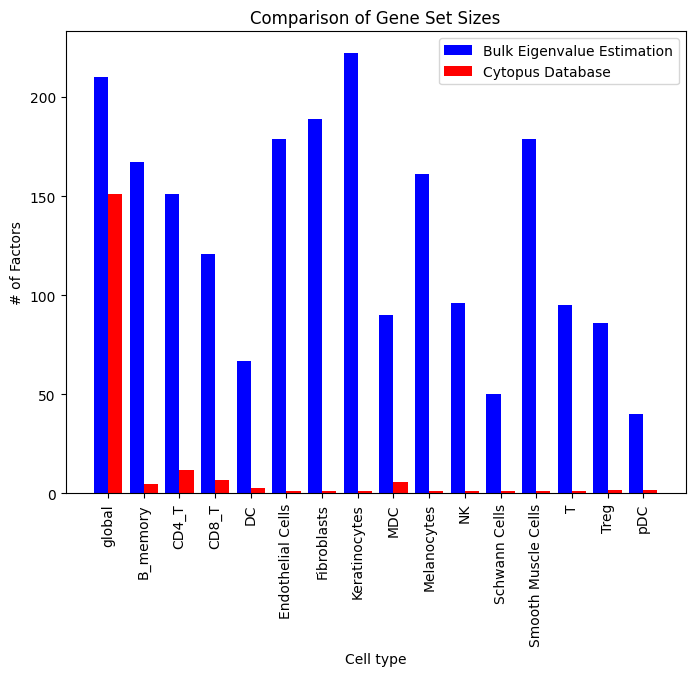

In [10]:
bulk_dict = adatas[(10000,True)].uns['SPECTRA_L']
def_dict = adatas[(10000,False)].uns['SPECTRA_L']
keys = bulk_dict.keys()
values1 = [bulk_dict[k] for k in keys]
values2 = [def_dict[k] for k in keys]

# Set bar width and positions
x = np.arange(len(keys))  # Positions for groups
width = 0.4  # Width of each bar

# Create figure and axis
plt.figure(figsize=(8, 6))

# Plot bars
plt.bar(x - width/2, values1, width, label='Bulk Eigenvalue Estimation', color='blue')
plt.bar(x + width/2, values2, width, label='Cytopus Database', color='red')

# Add labels and title
plt.xticks(x, keys, rotation=90)  # Set x-axis labels to dictionary keys
plt.xlabel("Cell type")
plt.ylabel("# of Factors")
plt.title("Comparison of Gene Set Sizes")
plt.legend()

# Show plot
plt.show()

## Assess Model Performance

### Assess Factor Coherence with Pairwise Mutual Distance

How well the genes within a factor are co-expressed across cells. A higher coherence score suggests a more functionally grouped factor.

In [4]:
def compute_gene_co_occurrences(factor_genes):
    """
    Compute the observed and expected co-occurrences for each gene pair.

    Parameters:
        factor_genes (ndarray): (num_factors x 50) array of top genes per factor.
        gene_frequencies (dict): Fraction of factors each gene appears in.

    Returns:
        dict: Normalized co-occurrence scores (Observed / Expected).
    """
    num_factors = factor_genes.shape[0]
    
    # Count occurrences of each gene across all factors, Normalize by the number of factors
    gene_counts = Counter(factor_genes.flatten())  
    gene_frequencies = {gene: count / num_factors for gene, count in gene_counts.items()}


    gene_to_factors = defaultdict(set)
    # Map each gene to the set of factors it appears in
    for factor_idx, genes in enumerate(factor_genes):
        for gene in genes:
            gene_to_factors[gene].add(factor_idx)

    co_occurrence_scores = {}
    for gene1, gene2 in itertools.combinations(gene_to_factors.keys(), 2):
        # Observed co-occurrence (number of factors where both genes appear)
        observed = len(gene_to_factors[gene1] & gene_to_factors[gene2])

        # Expected co-occurrence (random probability model)
        expected = gene_frequencies[gene1] * gene_frequencies[gene2] * num_factors

        # Compute normalized score (Observed / Expected)
        co_occurrence_scores[(gene1, gene2)] = observed / expected if expected > 0 else 0

    return co_occurrence_scores

def compute_factor_coherence(factor_genes):
    """
    Compute the average normalized co-occurrence rate for each factor.

    Parameters:
        factor_genes (ndarray): (num_factors x 50) array of top genes per factor.
        co_occurrence_scores (dict): Normalized co-occurrence scores.

    Returns:
        ndarray: Co-occurrence scores per factor.
    """
    co_occurrence_scores = compute_gene_co_occurrences(factor_genes)

    factor_scores = []

    for factor in factor_genes:
        normalized_co_occurrences = []
        for gene1, gene2 in itertools.combinations(factor, 2):
            score = co_occurrence_scores.get((gene1, gene2), 0)  # Lookup normalized score
            normalized_co_occurrences.append(score)
        
        # Compute the average normalized co-occurrence score for the factor
        factor_score = np.mean(normalized_co_occurrences) if normalized_co_occurrences else 0
        factor_scores.append(factor_score)

    return np.array(factor_scores)

In [5]:
co_occurrences = {}
for key in adatas.keys():
    co_occurrences[key] = compute_factor_coherence(adatas[key].uns['SPECTRA_markers'])

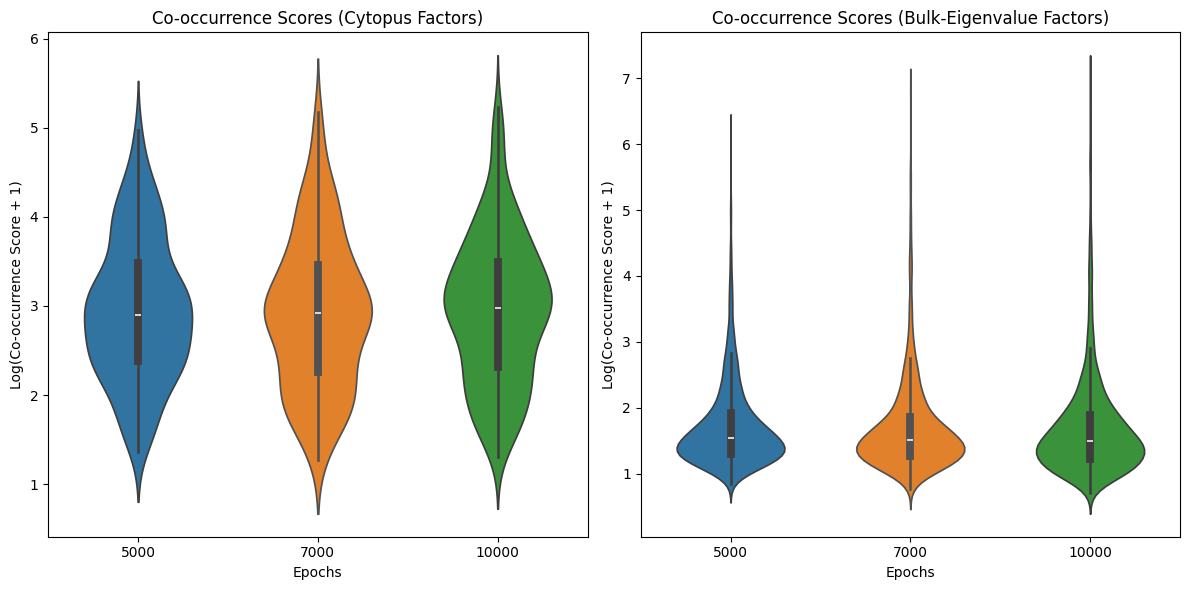

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
epochs = [5000, 7000, 10000]

# Plot each epoch's data at separate x positions using the x parameter
for idx, epoch in enumerate(epochs):
    bulked = co_occurrences[(epoch, True)]
    default = co_occurrences[(epoch, False)]
    
    # Add jittered x-values for separation (x=idx for each group)
    sns.violinplot(y=np.log1p(default), x=np.full(len(default), idx), 
                   ax=axes[0], width=0.6)
    sns.violinplot(y=np.log1p(bulked), x=np.full(len(bulked), idx), 
                   ax=axes[1], width=0.6)

# Customize axes
for ax, title in zip(axes, ["Cytopus Factors", "Bulk-Eigenvalue Factors"]):
    ax.set_title(f"Co-occurrence Scores ({title})")
    ax.set_ylabel("Log(Co-occurrence Score + 1)")
    ax.set_xlabel("Epochs")
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(epochs)  # Direct epoch labels on x-axis

plt.tight_layout()

### Judge How Well it Overlaps with Prior Knowledge

Did not implement this, but it can be done ~easily. We already have the closest overlapping pathway in the index name (# if none passed the threshold) and we can look at the overlap score against its closest pathway. I did not implement because we have very few provided gene sets to begin with.

In [14]:
index_labels_10k = adatas[(10000,True)].uns['SPECTRA_overlap'].index
gene_weights_10k = pd.DataFrame(adatas[(10000,True)].uns['SPECTRA_factors'],
                            index= index_labels_10k,
                            columns=adata.var[adata.var['spectra_vocab']].index)
gene_weights_10k

,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,DVL1,MXRA8,AURKAIP1,...,TKTL2,CYP4A22,CLDN2,SCGB1A1,CLDN17,IL25,ATP6V1G3,AGXT2,FABP1,UPP2
0-X-global-X-all_biotin_metabolism,1.186582e-13,4.394065e-15,5.023325e-18,1.890173e-17,4.100478e-06,1.794354e-17,1.601197e-14,2.228458e-09,6.877578e-15,3.396698e-15,...,9.481122e-18,1.534130e-20,3.579215e-20,1.432343e-17,1.268827e-20,3.907646e-16,2.226606e-18,1.104263e-17,4.957649e-20,9.011098e-21
1-X-global-X-all_purine_metabolism,6.236306e-14,1.736226e-15,1.142710e-17,4.046773e-17,3.171008e-13,3.609819e-17,3.249722e-16,7.542399e-13,1.679128e-18,3.017356e-14,...,8.846523e-17,2.966740e-19,7.318299e-17,5.322549e-17,8.630482e-17,6.024903e-16,3.849184e-17,4.970997e-17,3.916142e-16,1.082877e-13
2-X-global-X-all_ethanol_metabolism,1.625687e-14,8.997771e-16,2.560090e-19,6.595480e-20,1.972283e-14,8.398646e-15,7.423331e-18,1.365133e-14,4.109592e-20,4.540811e-16,...,9.991896e-17,4.233310e-15,3.349611e-20,1.094713e-16,3.901722e-17,4.223094e-16,1.542891e-17,3.866044e-17,7.826435e-16,1.072299e-17
3-X-global-X-all_amino-sugar-nucleotide-sugar_metabolism,2.124323e-14,1.511399e-15,4.370515e-17,6.344148e-18,5.336961e-13,2.714245e-15,7.908017e-15,2.188805e-13,9.853366e-19,4.800752e-14,...,5.761100e-17,1.559367e-18,2.050104e-17,5.634636e-17,2.272046e-17,5.397619e-16,4.541308e-17,3.691588e-17,8.432404e-17,1.454811e-20
4-X-global-X-all_steroid_metabolism,1.038051e-14,1.498569e-14,1.167085e-18,5.212324e-19,1.784603e-12,2.756859e-17,1.179943e-16,2.061387e-13,1.336513e-19,1.179312e-14,...,5.044376e-17,7.680968e-13,1.031418e-16,5.246441e-17,2.000624e-16,8.297850e-16,2.632959e-17,2.251884e-17,2.265250e-15,1.434525e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098-X-pDC-X-all_TNF-via-NFkB_signaling,6.931385e-08,3.584967e-17,8.477346e-17,8.179194e-17,1.320919e-16,1.219708e-16,3.813007e-18,5.220266e-18,4.495488e-18,3.392119e-16,...,2.906439e-18,3.787265e-18,7.504958e-18,5.246927e-18,5.046901e-18,1.468374e-18,4.244570e-18,3.251666e-18,1.186624e-17,5.381116e-18
2099-X-pDC-X-all_TNF-via-NFkB_signaling,1.258054e-06,3.003895e-07,5.532259e-16,1.080479e-06,6.673268e-16,4.135988e-17,7.989387e-08,1.435783e-17,5.365085e-18,5.389970e-16,...,1.223671e-17,6.092360e-18,1.548146e-17,2.305674e-18,8.316078e-18,1.155322e-17,8.952734e-19,9.264901e-18,1.137593e-17,6.012235e-18
2100-X-pDC-X-CD8-T_terminal-exhaustion,2.047369e-15,6.944027e-08,5.118866e-16,9.425684e-19,5.053758e-17,1.392436e-08,5.244574e-17,3.354564e-18,4.957617e-18,4.077646e-08,...,9.336615e-18,1.432519e-17,1.289066e-17,6.819673e-18,1.093274e-17,6.000643e-18,3.725897e-18,7.365576e-18,5.376766e-18,6.368210e-18
2101-X-pDC-X-all_TNF-via-NFkB_signaling,4.565428e-14,2.784623e-11,5.704857e-16,1.929659e-14,6.967531e-17,4.487064e-17,1.534349e-17,5.639072e-18,4.703779e-18,3.368253e-15,...,5.615103e-18,5.559401e-18,8.899211e-18,6.949591e-18,2.824529e-18,7.229795e-18,1.714824e-18,4.582157e-18,7.730501e-18,5.064625e-18


### Judge the Structure of Cell Scores

For every factor, see the distribution of cell scores. We should ideally see a bimodal distribution, where genes not in the factor are 0 and genes in the factor are some expression level.

In [6]:
def analyze_distributions(data, factor_names=None):
    """
    Analyze and visualize the distribution of scores for each factor on a single plot.
    
    Parameters:
    data : numpy.ndarray
        Array of shape (n_cells, n_factors) containing scores
    factor_names : list, optional
        Names of the factors. If None, will use "Factor 1", "Factor 2", etc.
    
    Returns:
    dict : Dictionary containing bimodality statistics for each factor
    """
    n_cells, n_factors = data.shape
    if factor_names is None:
        factor_names = [f"Factor {i+1}" for i in range(n_factors)]

    results = {}
    for i in range(n_factors):
        factor_data = data[:, i]
        
        # Calculate statistics
        results[factor_names[i]] = {}
        results[factor_names[i]]['mean'] = np.mean(factor_data)
        results[factor_names[i]]['std'] = np.std(factor_data)
        
        # Test for bimodality using Hartigan's dip test
        try:
            dip, pval = diptest(factor_data)
            results[factor_names[i]]['dip_statistic'] = dip
            results[factor_names[i]]['dip_p_value'] = pval
        except ImportError:
            # Alternative bimodality detection using peaks in KDE
            kde = stats.gaussian_kde(factor_data)
            x_range = np.linspace(min(factor_data), max(factor_data), 200)
            y = kde(x_range)
            peaks, _ = find_peaks(y)
            results[factor_names[i]]['num_peaks'] = len(peaks)
            
        results[factor_names[i]]['skewness'] = stats.skew(factor_data)
        results[factor_names[i]]['kurtosis'] = stats.kurtosis(factor_data)
    return results

In [7]:
cell_score_structure = {}
for key in adatas.keys():
    cell_score_structure[key] = analyze_distributions(adatas[key].obsm['SPECTRA_cell_scores'], factor_names=list(adatas[key].uns['SPECTRA_overlap'].index))

/c4/home/sanjayr/.conda/envs/spectra_kernel/lib/python3.9/site-packages/diptest/consts.py:702: UserWarning: Sample size exceeds the maximum limit of 72000. Results may not be accurate with precomputed statistical values.
  warnings.warn(


In [12]:
adatas[(10000,True)]

AnnData object with n_obs × n_vars = 100000 × 28683
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'doubletFinderScore', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'percent.ribo', 'isotype_ctl_max', 'S.Score', 'G2M.Score', 'Phase', 'pool', 'batch', 'biospecimen', 'individual', 'subtype', 'disease_group', 'years_since_diagnosis', 'Age', 'Sex at Birth', 'sample_type', 'd_sample_type', 'location', 'cluster_label', 'spectra_annotation', 'combined_annotation'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'spectra_vocab'
    uns: 'SPECTRA_factors', 'SPECTRA_markers', 'SPECTRA_L', 'SPECTRA_overlap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'SPECTRA_cell_scores'
    varm: 'HARMONY', 'PCs'

In [8]:
cell_score_structure

{(10000,
  True): {'0-X-global-X-all_biotin_metabolism': {'mean': np.float64(0.0004193159491604082),
   'std': np.float64(0.001002385627809534),
   'dip_statistic': 0.0004885366535801177,
   'dip_p_value': 1.0,
   'skewness': np.float64(4.4545253413662635),
   'kurtosis': np.float64(38.5357730020127)}, '1-X-global-X-all_purine_metabolism': {'mean': np.float64(0.00012212948304335288),
   'std': np.float64(0.00022233138379378718),
   'dip_statistic': 0.0332426579640509,
   'dip_p_value': 0.0,
   'skewness': np.float64(3.494135320850014),
   'kurtosis': np.float64(22.287536508292593)}, '2-X-global-X-all_ethanol_metabolism': {'mean': np.float64(2.0277937967463166e-05),
   'std': np.float64(8.264790214714156e-05),
   'dip_statistic': 0.02080443935096463,
   'dip_p_value': 0.0,
   'skewness': np.float64(9.94508487693034),
   'kurtosis': np.float64(208.4842804235067)}, '3-X-global-X-all_amino-sugar-nucleotide-sugar_metabolism': {'mean': np.float64(0.00013904987808006957),
   'std': np.float64

In [18]:
epochs = [5000, 7000, 10000]
dip_metrics = {}
bulk_dip_metrics = {}

for epoch in epochs:
    #Create a way to track the bimodalities of factors for a given epoch
    dip_stats = []
    p_vals = []

    factors = cell_score_structure[(epoch, False)].values()
    for factor in factors:
        dip_stats.append(factor['dip_statistic'])
        p_vals.append(factor['dip_p_value'])
    
    #Add to total stats
    dip_metrics[epoch] = {
        'dip_stats': np.array(dip_stats),
        'p_values': np.array(p_vals)
    }

    dip_stats_bulk = []
    p_vals_bulk = []

    bulk_factors = cell_score_structure[(epoch, True)].values()
    for bfactor in bulk_factors:
        dip_stats_bulk.append(bfactor['dip_statistic'])
        p_vals_bulk.append(bfactor['dip_p_value'])

    bulk_dip_metrics[epoch] = {
        'dip_stats': np.array(dip_stats_bulk),
        'p_values': np.array(p_vals_bulk)
    }

def bimodal_figure(data, title=''):
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 3]})

    # Panel 1: Percentage of significant bimodal factors per epoch
    sig_percentages = []
    for epoch in epochs:
        num_factors = len(data[epoch]['p_values'])
        sig_count = np.sum(data[epoch]['p_values'] < 0.05)
        sig_percentages.append(sig_count / num_factors)

    ax1.bar(range(len(epochs)), sig_percentages, color='skyblue', edgecolor='black')
    ax1.set_xticks(range(len(epochs)))
    ax1.set_xticklabels(epochs)
    ax1.set_ylabel('# Significant Factors\n(p < 0.05)', fontsize=10)
    ax1.set_title(f'% of Bimodal Factors by Epoch Size- {title}', pad=20)

    # Panel 2: Dip statistic vs p-value with epoch comparison
    colors = {'5000': '#1f77b4', '7000': '#ff7f0e', '10000': '#2ca02c'}
    for epoch in epochs:
        epoch_data = data[epoch]
        ax2.scatter(
            epoch_data['dip_stats'],
            -np.log10(epoch_data['p_values']),
            c=colors[str(epoch)],
            label=f'{epoch} epochs',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.5
        )

    ax2.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1)
    ax2.set_xlabel('Dip Statistic (Bimodality Strength)', fontsize=10)
    ax2.set_ylabel('-log10(p-value)', fontsize=10)
    ax2.set_title(f'Bimodality Landscape Comparison- {title}', pad=15)
    ax2.legend(title='Epoch Size', frameon=True)

    plt.tight_layout()
    plt.show()


/scratch/sanjayr/361254/ipykernel_101883/1163155546.py:32: RuntimeWarning: divide by zero encountered in log10
  -np.log10(bulk_dip_metrics[epoch]['p_values']),
/scratch/sanjayr/361254/ipykernel_101883/1163155546.py:37: RuntimeWarning: divide by zero encountered in log10
  -np.log10(dip_metrics[epoch]['p_values']),


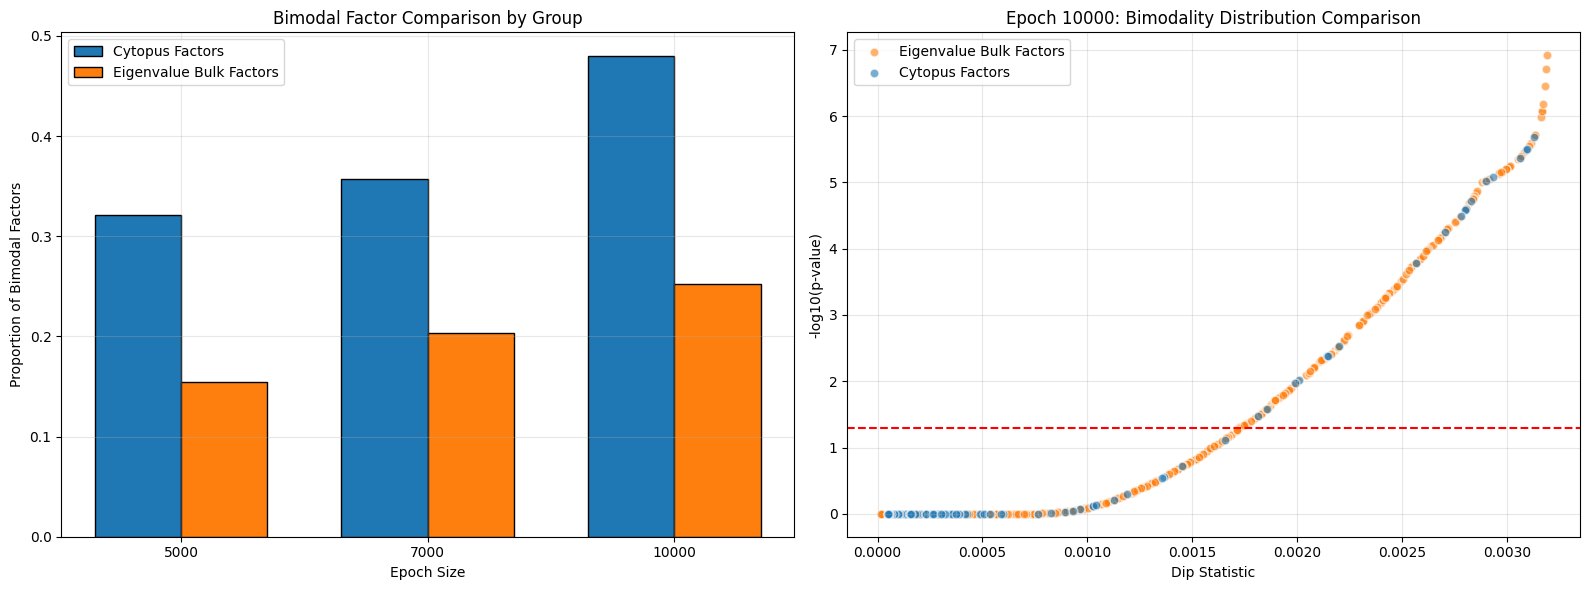

In [19]:
# First: Bar plot comparing both groups across epochs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot configuration
bar_width = 0.35
x_pos = np.arange(len(epochs))
colors = {'default': '#1f77b4', 'bulk': '#ff7f0e'}

# Calculate significant percentages for both groups
sig_default = [np.sum(dip_metrics[e]['p_values'] < 0.05)/len(dip_metrics[e]['p_values']) for e in epochs]
sig_bulk = [np.sum(bulk_dip_metrics[e]['p_values'] < 0.05)/len(bulk_dip_metrics[e]['p_values']) for e in epochs]

# Plot bars side by side
ax1.bar(x_pos - bar_width/2, sig_default, width=bar_width, 
        color=colors['default'], edgecolor='black', label='Cytopus Factors')
ax1.bar(x_pos + bar_width/2, sig_bulk, width=bar_width,
        color=colors['bulk'], edgecolor='black', label='Eigenvalue Bulk Factors')

# Format bar plot
ax1.set_xticks(x_pos)
ax1.set_xticklabels(epochs)
ax1.set_xlabel('Epoch Size')
ax1.set_ylabel('Proportion of Bimodal Factors')
ax1.set_title('Bimodal Factor Comparison by Group')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Second: Scatter plot for 10k epoch only
epoch = 10000

ax2.scatter(bulk_dip_metrics[epoch]['dip_stats'],
           -np.log10(bulk_dip_metrics[epoch]['p_values']),
           color=colors['bulk'], alpha=0.6,
           label='Eigenvalue Bulk Factors', edgecolor='w', s=40)

ax2.scatter(dip_metrics[epoch]['dip_stats'],
           -np.log10(dip_metrics[epoch]['p_values']),
           color=colors['default'], alpha=0.6,
           label='Cytopus Factors', edgecolor='w', s=40)

# Format scatter plot
ax2.axhline(-np.log10(0.05), color='red', linestyle='--')
ax2.set_xlabel('Dip Statistic')
ax2.set_ylabel('-log10(p-value)')
ax2.set_title(f'Epoch {epoch}: Bimodality Distribution Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/scratch/sanjayr/361254/ipykernel_101883/2005128043.py:57: RuntimeWarning: divide by zero encountered in log10
  -np.log10(epoch_data['p_values']),


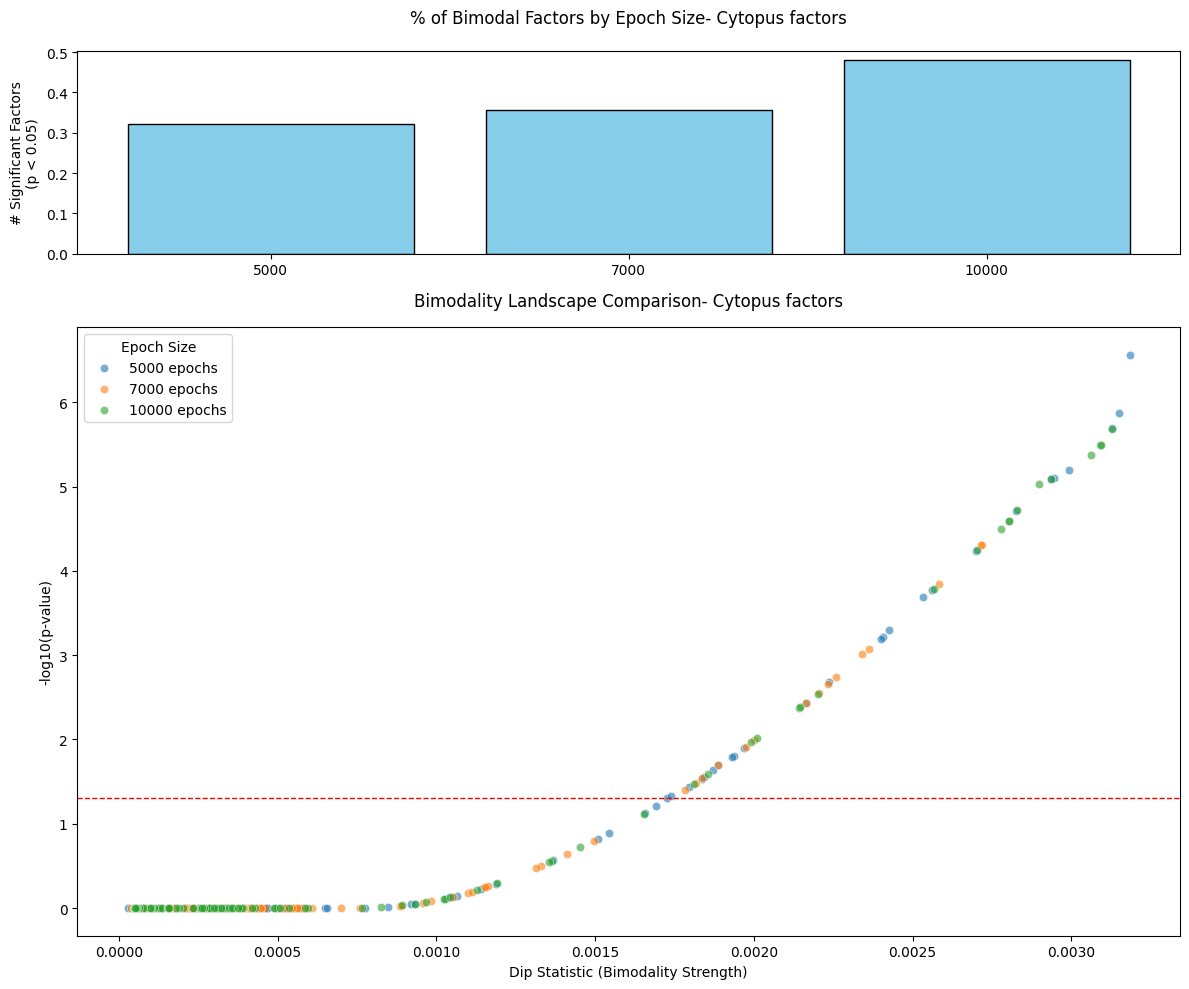

In [20]:
bimodal_figure(dip_metrics, 'Cytopus factors')

/scratch/sanjayr/361254/ipykernel_101883/2005128043.py:57: RuntimeWarning: divide by zero encountered in log10
  -np.log10(epoch_data['p_values']),


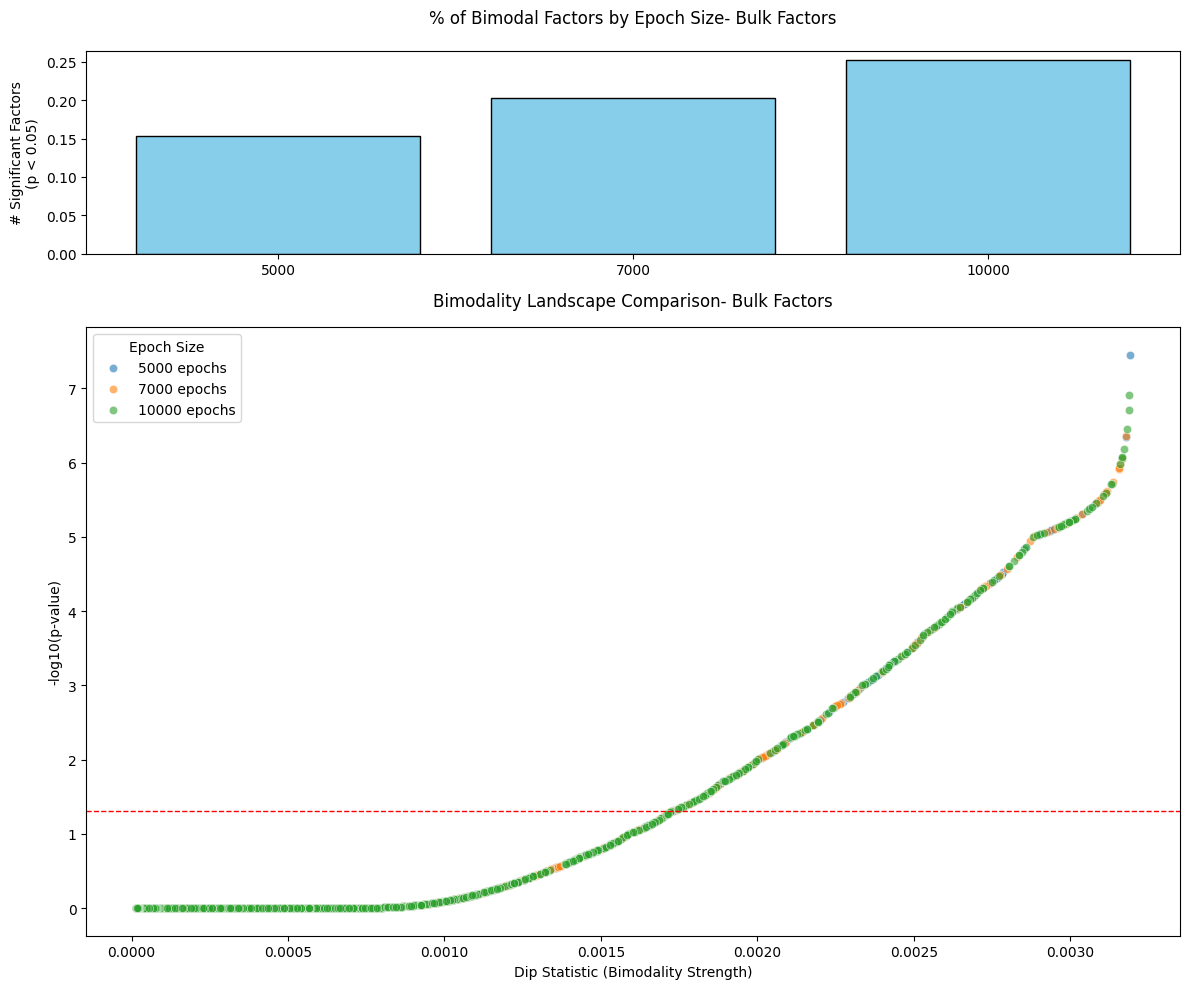

In [21]:
bimodal_figure(bulk_dip_metrics, 'Bulk Factors')

In [22]:
with open(f'models/skin_model_-1cells_1epochs_bulkTrue_1000genes.pickle', 'rb') as f:
    model = pickle.load(f)

In [ ]:
with open('adatas/skin_data_-1cells_1epochs_bulkTrue_1000genes.pickle', 'rb') as f:
    data = pickle.load(f)

: 

: 

: 

In [ ]:
data

AnnData object with n_obs × n_vars = 261290 × 28683
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'doubletFinderScore', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'percent.ribo', 'isotype_ctl_max', 'S.Score', 'G2M.Score', 'Phase', 'pool', 'batch', 'biospecimen', 'individual', 'subtype', 'disease_group', 'years_since_diagnosis', 'Age', 'Sex at Birth', 'sample_type', 'd_sample_type', 'location', 'cluster_label', 'spectra_annotation', 'combined_annotation'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'spectra_vocab'
    uns: 'SPECTRA_factors', 'SPECTRA_markers', 'SPECTRA_L', 'SPECTRA_overlap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'SPECTRA_cell_scores'
    varm: 'HARMONY', 'PCs'

In [ ]:
data.uns['SPECTRA_overlap'][['fibro_IL4_response']]

,fibro_IL4_response
0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis,0.000000
1-X-global-X-all_retinol_metabolism,0.000000
2-X-global-X-all_RIG-I-like-receptor_signaling,0.000000
3-X-global-X-all_propanoate_metabolism,0.000000
4-X-global-X-all_p53-signaling,0.052632
...,...
2098-X-pDC-X-2098,0.000000
2099-X-pDC-X-2099,0.000000
2100-X-pDC-X-2100,0.000000
2101-X-pDC-X-2101,0.000000


In [ ]:
pldssssss

## Extra Stuff

In [ ]:
def analyze_bimodality(data, title="Distribution Analysis"):
    """
    Analyze an array for bimodality using multiple visualization techniques
    and statistical tests.
    
    Parameters:
    data : numpy.ndarray
        1D array of values to analyze
    title : str
        Title for the plot
    """
    # Create figure with multiple plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Histogram with KDE
    sns.histplot(data=data, kde=True, ax=ax1)
    ax1.set_title('Histogram with KDE')
    
    # 2. Violin plot
    sns.violinplot(data=data, ax=ax2)
    ax2.set_title('Violin Plot')
    
    # 3. Box plot with individual points
    sns.boxplot(data=data, ax=ax3)
    sns.stripplot(data=data, color='red', alpha=0.3, ax=ax3)
    ax3.set_title('Box Plot with Data Points')
    
    # 4. QQ plot to check for normality
    stats.probplot(data, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot')
    
    # Adjust layout
    plt.tight_layout()
    
    # Calculate statistics
    dip_stat, p_value = diptest(data)
    kurtosis = stats.kurtosis(data)
    skewness = stats.skew(data)
    
    # Print statistical results
    print("\nBimodality Analysis Results:")
    print(f"Hartigan's Dip Test:")
    print(f"  - Dip statistic: {dip_stat:.4f}")
    print(f"  - P-value: {p_value:.4f}")
    print(f"  - {'Evidence for multimodality' if p_value < 0.05 else 'No strong evidence for multimodality'}")
    print(f"\nDistribution Shape:")
    print(f"  - Kurtosis: {kurtosis:.4f}")
    print(f"  - Skewness: {skewness:.4f}")
    
    return fig

/c4/home/sanjayr/.conda/envs/spectra_kernel/lib/python3.9/site-packages/diptest/consts.py:702: UserWarning: Sample size exceeds the maximum limit of 72000. Results may not be accurate with precomputed statistical values.
  warnings.warn(



Bimodality Analysis Results:
Hartigan's Dip Test:
  - Dip statistic: 0.0332
  - P-value: 0.0000
  - Evidence for multimodality

Distribution Shape:
  - Kurtosis: 22.2875
  - Skewness: 3.4941


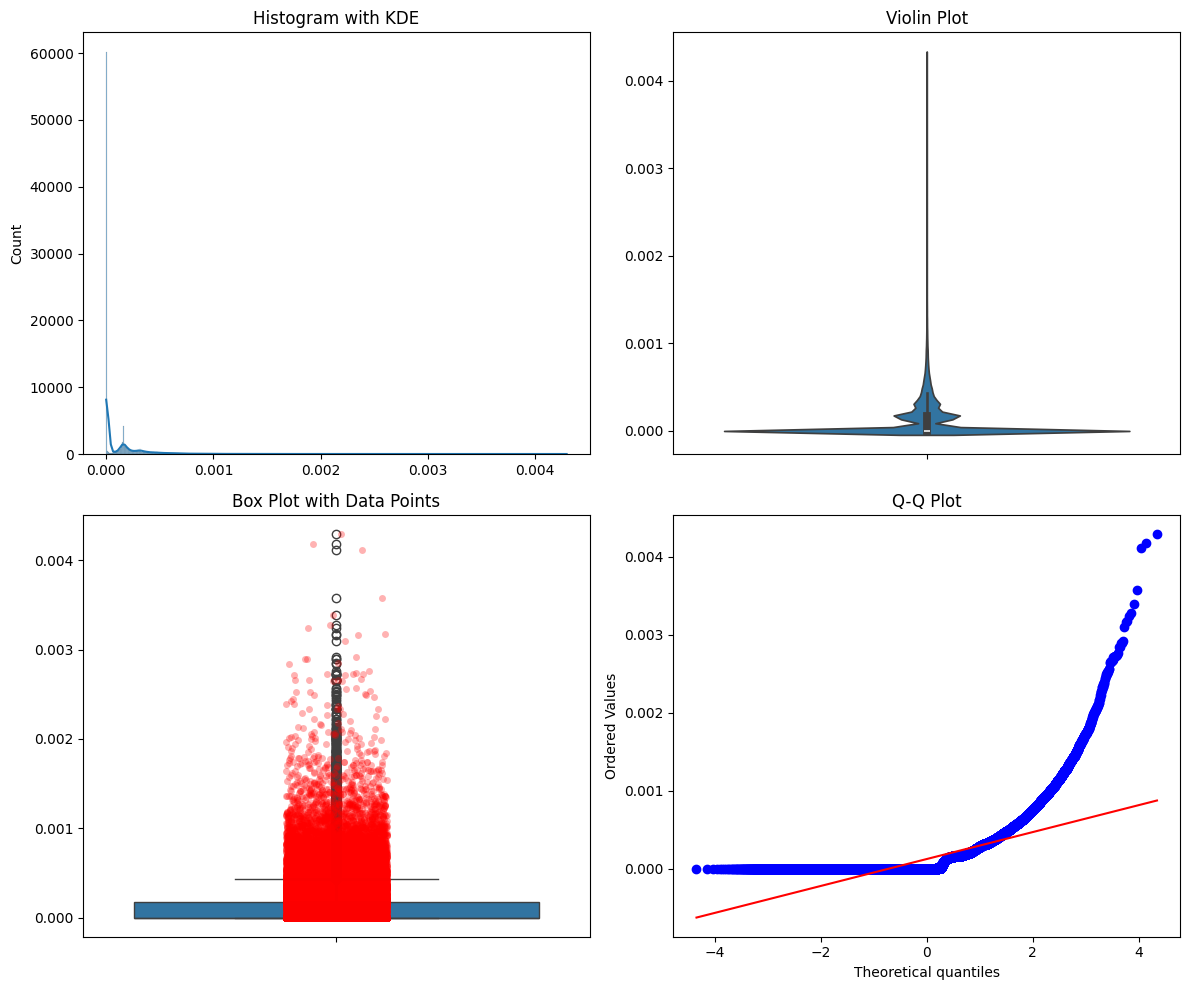

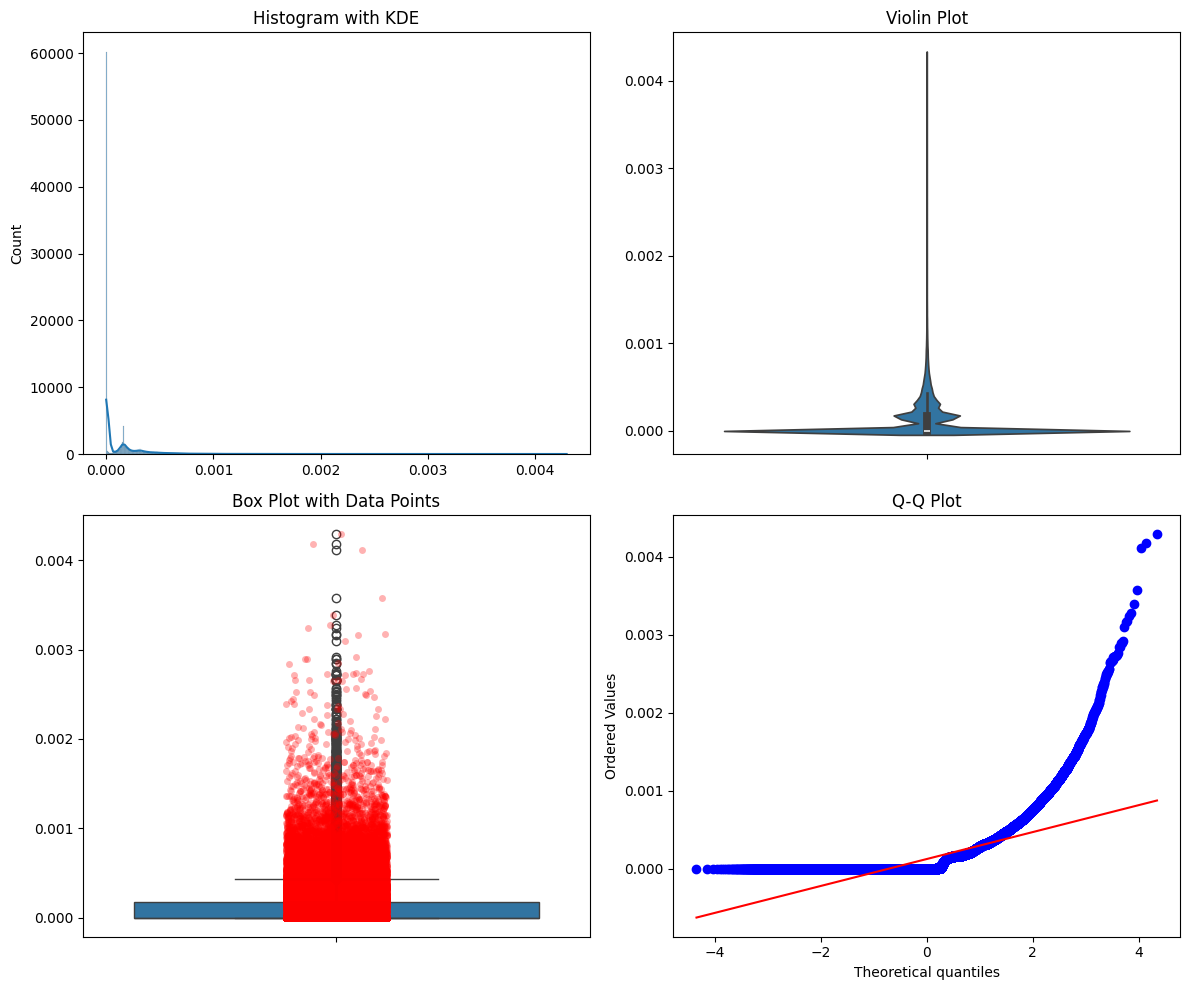

In [ ]:
analyze_bimodality(adatas[(10000,True)].obsm['SPECTRA_cell_scores'][:,1])

In [ ]:
index_labels_7k = adatas[(7000,True)].uns['SPECTRA_overlap'].index
gene_weights_7k = pd.DataFrame(adatas[(7000,True)].uns['SPECTRA_factors'],
                            index= index_labels_7k,
                            columns=adata.var[adata.var['spectra_vocab']].index)
gene_weights_7k

,HES4,ISG15,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,DVL1,MXRA8,AURKAIP1,...,TKTL2,CYP4A22,CLDN2,SCGB1A1,CLDN17,IL25,ATP6V1G3,AGXT2,FABP1,UPP2
0-X-global-X-all_biotin_metabolism,3.226495e-17,7.355107e-17,2.708933e-18,2.565350e-17,3.388138e-05,8.746742e-14,7.296315e-09,6.183651e-13,4.991036e-16,1.789628e-09,...,1.520061e-16,5.339456e-19,7.611994e-19,3.786884e-17,3.040119e-19,1.346368e-16,4.819262e-24,2.229458e-17,2.643012e-16,2.083000e-20
1-X-global-X-1,2.136829e-14,7.756459e-17,1.072220e-16,1.217615e-16,3.140951e-12,5.117027e-17,4.979899e-18,1.132287e-15,3.632145e-17,4.848837e-12,...,5.451917e-18,3.021722e-17,9.382860e-16,1.228675e-18,1.391373e-17,1.253565e-16,7.945482e-13,1.192633e-17,9.489747e-18,1.076907e-17
2-X-global-X-all_ethanol_metabolism,5.463970e-17,4.874353e-17,1.541567e-19,5.165488e-18,8.684237e-14,1.350464e-15,4.689949e-14,3.701432e-16,5.528905e-20,4.637121e-08,...,1.961399e-16,5.697571e-16,6.798398e-21,3.422504e-16,1.558074e-17,9.469467e-17,3.242146e-24,3.538054e-18,4.046961e-19,7.447052e-21
3-X-global-X-all_amino-sugar-nucleotide-sugar_metabolism,2.810899e-14,2.023595e-16,5.367953e-17,6.583882e-17,1.477166e-08,4.922795e-15,8.618861e-10,7.692203e-16,1.013900e-18,1.875016e-10,...,3.793633e-16,3.067925e-18,2.412167e-17,2.490073e-17,8.335357e-19,1.081942e-16,8.036153e-24,4.165788e-17,1.729332e-19,5.211671e-20
4-X-global-X-all_steroid_metabolism,2.469822e-14,5.116313e-17,8.352959e-17,1.676108e-16,4.198832e-13,1.416651e-16,9.541617e-18,1.086184e-15,1.851918e-18,1.518179e-11,...,7.876156e-17,1.161131e-17,1.771144e-16,3.912788e-18,1.846166e-16,9.288259e-17,1.220538e-23,9.664861e-20,2.851890e-17,8.794082e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098-X-pDC-X-CD8-T_terminal-exhaustion,2.672018e-18,3.045237e-07,2.954353e-16,2.438472e-07,2.524795e-15,9.779648e-20,1.721308e-15,2.004064e-18,1.307757e-18,6.156089e-21,...,7.903299e-18,2.974780e-18,6.506021e-18,2.707441e-18,2.404987e-18,6.925426e-18,8.410803e-18,7.306514e-18,5.844093e-18,5.579730e-18
2099-X-pDC-X-2099,1.995129e-17,3.172963e-07,4.913642e-08,2.385738e-15,8.811755e-16,4.201537e-14,1.838782e-15,3.853220e-18,1.687425e-18,1.390832e-18,...,2.827904e-18,7.545047e-18,8.267539e-18,1.863381e-18,1.235349e-18,3.906062e-18,7.251782e-18,5.858800e-18,5.148745e-18,1.604754e-18
2100-X-pDC-X-DC_antigen-crosspresentation,2.140501e-18,1.246674e-15,5.373095e-14,1.129451e-06,2.713716e-07,2.595733e-15,2.389827e-15,1.809285e-18,4.295794e-19,4.880308e-18,...,7.635575e-18,1.655973e-18,5.973610e-18,4.635194e-18,4.388957e-18,3.024698e-18,6.734901e-18,3.490425e-18,5.736592e-18,3.437034e-18
2101-X-pDC-X-2101,9.301351e-18,6.525899e-13,4.311959e-16,3.018401e-10,1.024052e-07,2.662839e-16,1.729765e-07,5.986408e-18,2.431404e-18,8.237950e-20,...,5.969342e-18,4.230580e-18,5.214212e-18,3.681344e-18,4.005043e-18,1.885745e-18,6.148594e-18,3.393673e-18,4.604841e-18,1.896837e-18


In [ ]:
adatas[(7000,True)].uns['SPECTRA_markers']

array([['BTD', 'CCDC80', 'HLCS', ..., 'PSIP1', 'UBE2D2', 'SDF4'],
       ['LGALS7B', 'DMKN', 'AREG', ..., 'PSME2', 'LMNA', 'AMPD3'],
       ['ALDH1A1', 'ZADH2', 'ALDH3A1', ..., 'CALM2', 'MPLKIP', 'USP53'],
       ...,
       ['MALAT1', 'CCR7', 'MIR155HG', ..., 'ADAM19', 'GNA15', 'SSR1'],
       ['FTH1', 'ATF3', 'RGS2', ..., 'RPL28', 'GADD45A', 'SOCS3'],
       ['EGLN3', 'JCHAIN', 'IL3RA', ..., 'SLC20A1', 'RALA', 'DUSP5']],
      dtype=object)

In [ ]:
adatas[(7000,True)].uns['SPECTRA_markers'].shape

(2103, 50)

In [ ]:
adatas[(10000,True)].uns['SPECTRA_markers'].shape

(2103, 50)

In [ ]:
pd.DataFrame(adatas[(10000,True)].obsm['SPECTRA_cell_scores'], index=adatas[(10000,True)].obs['combined_annotation'])

,0,1,2,3,4,5,6,7,8,9,...,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102
combined_annotation,,,,,,,,,,,,,,,,,,,,,
Endothelial Cells,8.467323e-11,7.817759e-12,6.368138e-12,9.795389e-12,2.437995e-06,2.147300e-10,5.849391e-11,5.030458e-11,1.050276e-11,1.081211e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Smooth Muscle Cells,2.122888e-09,1.601451e-04,7.905604e-10,3.130802e-04,1.817482e-10,3.791226e-11,2.712533e-03,2.585967e-10,1.901767e-11,4.257356e-11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Keratinocytes,2.557368e-03,3.155023e-04,1.155218e-11,4.099484e-04,1.282747e-02,6.187672e-04,1.943969e-10,1.198193e-03,2.446188e-03,2.824865e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Endothelial Cells,3.464295e-04,2.110751e-09,1.328067e-11,1.649228e-11,1.989647e-11,5.184306e-04,2.199558e-10,8.771342e-11,2.468439e-11,1.610252e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fibroblasts,3.340794e-09,3.688907e-11,1.409725e-11,1.949227e-08,3.926917e-11,1.292022e-10,3.431286e-04,6.620577e-11,2.899138e-11,4.587523e-11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Keratinocytes,9.712071e-10,5.347166e-04,4.367329e-06,9.701461e-04,1.808011e-04,1.411502e-10,5.669940e-12,8.844850e-11,5.546513e-04,6.160643e-04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Endothelial Cells,4.447341e-08,6.767197e-10,3.095194e-12,4.810774e-10,1.028928e-08,1.003442e-10,4.842504e-04,2.311103e-04,9.277042e-12,5.027263e-11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Endothelial Cells,9.848652e-11,3.094066e-04,2.028716e-11,1.240524e-04,3.798208e-11,1.651802e-10,9.945931e-12,3.175380e-04,6.141887e-12,4.965757e-11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
adatas[(2000,False)].uns['SPECTRA_factors'].shape

(196, 6297)

In [ ]:
dir(models[0])

['B_diag',
 'L',
 '_SPECTRA_Model__B_diag',
 '_SPECTRA_Model__eta_matrices',
 '_SPECTRA_Model__store_parameters',
 '_SPECTRA_Model__store_parameters_no_celltypes',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cell_scores',
 'delta',
 'eta_matrices',
 'factors',
 'gene_scalings',
 'initialize',
 'internal_model',
 'kappa',
 'lam',
 'load',
 'matching',
 'return_cell_scores',
 'return_eta',
 'return_eta_diag',
 'return_factors',
 'return_gene_scalings',
 'return_graph',
 'return_kappa',
 'return_rho',
 'rho',
 'save',
 'train',
 'use_cell_types']

In [ ]:
models[0].return_factors().shape

(196, 6297)

In [ ]:
models[0].internal_model

SPECTRA(
  (theta): ParameterDict(
      (global): Parameter containing: [torch.FloatTensor of size 6297x151]
      (B_memory): Parameter containing: [torch.FloatTensor of size 6297x5]
      (CD4_T): Parameter containing: [torch.FloatTensor of size 6297x12]
      (CD8_T): Parameter containing: [torch.FloatTensor of size 6297x7]
      (DC): Parameter containing: [torch.FloatTensor of size 6297x3]
      (Endothelial Cells): Parameter containing: [torch.FloatTensor of size 6297x1]
      (Fibroblasts): Parameter containing: [torch.FloatTensor of size 6297x1]
      (Keratinocytes): Parameter containing: [torch.FloatTensor of size 6297x1]
      (MDC): Parameter containing: [torch.FloatTensor of size 6297x6]
      (Melanocytes): Parameter containing: [torch.FloatTensor of size 6297x1]
      (NK): Parameter containing: [torch.FloatTensor of size 6297x1]
      (Schwann Cells): Parameter containing: [torch.FloatTensor of size 6297x1]
      (Smooth Muscle Cells): Parameter containing: [torch.Floa